In [1]:
#!/usr/bin/env python
# coding: utf-8

import numpy as np 
import pandas as pd 

import lightgbm as lgb
import xgboost as xgb  
from sklearn.linear_model import LogisticRegression  # 导入逻辑回归
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_recall_curve, roc_curve
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler  # 新增标准化器
import gc
import os
import time
import sys
import datetime
import pickle
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import metrics

# 可视化相关库
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=1.2)

# 设置中文字体，解决乱码问题
plt.rcParams["font.family"] = ["SimHei", "WenQuanYi Micro Hei", "Heiti TC"]
sns.set(font='SimHei', font_scale=0.8)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

E:\anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
E:\anaconda\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=True, fit_path=True,
E:\anaconda\lib\site-pa

In [2]:
# 数据读取
train = pd.read_csv('../data/train.csv')
label = pd.read_csv('../data/train_label.csv')
test = pd.read_csv('../data/test.csv')
sub = pd.read_csv('../data/submission.csv')

# 特征工程
df_source = train.merge(label,on='ID',how='left')
test['label'] = -1
train = train.merge(label,on='ID',how='left')
data = pd.concat([train, test])

# 提取时间特征
def get_time_fe(df):
    df['day'] = df.date.apply(lambda x:int(x[8:10]))
    df['hour'] = df.date.apply(lambda x:int(x[11:13]))
    return df

# 时间分箱
def getSeg(x):
    if x >=0 and x<= 3:
        return 1
    elif x>=4 and x<=12:
        return 2
    elif x>=13 and x<=18:
        return 3
    elif x>=19 and x<=23:
        return 1

# count统计特征
cross_feature = []
def get_cross_fe(df):
    first_feature = [ 'B2', 'B3']
    second_feature = ['C1','C2','C3','D1','A1','A2','A3']
    for feat_1 in first_feature:
        for feat_2 in second_feature:
            col_name = "cross_" + feat_1 + "_and_" + feat_2
            cross_feature.append(col_name)
            df[col_name] = df[feat_1].astype(str).values + '_' + df[feat_2].astype(str).values
    return df

# 获取nunique特征
def get_nunique_1_fe(df):
    adid_nuq = [ 'hour','E1','E14','B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A2')[feat].nunique().reset_index().rename(columns={feat: "A2_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A2'].nunique().reset_index().rename(columns={'A2': "%s_A2_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A2'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df
def get_nunique_2_fe(df):
    adid_nuq = [ 'E1','E14']
    for feat in adid_nuq:
        gp1 = df.groupby('hour')[feat].nunique().reset_index().rename(columns={feat: "hour_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['hour'].nunique().reset_index().rename(columns={'hour': "%s_hour_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['hour'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df

def get_nunique_4_fe(df):
    adid_nuq = [ 'B2','B3']
    for feat in adid_nuq:
        gp1 = df.groupby('A1')[feat].nunique().reset_index().rename(columns={feat: "A1_%s_nuq_num" % feat})
        gp2 = df.groupby(feat)['A1'].nunique().reset_index().rename(columns={'A1': "%s_A1_nuq_num" % feat})
        df = pd.merge(df, gp1, how='left', on=['A1'])
        df = pd.merge(df, gp2, how='left', on=[feat])
    return df

# 应用特征工程
data = get_time_fe(data)
data = get_cross_fe(data)
data = get_nunique_1_fe(data)
data = get_nunique_2_fe(data)

# 标签编码
cate_feature = ['A1','A2','A3','B1','B2','B3','C1','C2','C3','E2','E3','E5','E7','E9','E10','E13','E16','E17','E19','E21','E22']
cate_features = cate_feature + cross_feature
for item in cate_features:
    data[item] = LabelEncoder().fit_transform(data[item])

# 计数特征
def feature_count(data, features=[]):
    new_feature = 'count'
    for i in features:
        new_feature += '_' + i
    try:
        del data[new_feature]
    except:
        pass
    temp = data.groupby(features).size().reset_index().rename(columns={0: new_feature})
    data = data.merge(temp, 'left', on=features)
    return data

for i in cross_feature:
    n = data[i].nunique()
    if n > 5:
        data = feature_count(data, [i])
    else:
        print(i, ':', n)

# 比例特征
label_feature =[ 'A2', 'A3','hour']
data_temp = data[label_feature]
df_feature = pd.DataFrame()
data_temp['cnt'] = 1
print('Begin ratio clcik...')
col_type = label_feature.copy()
n = len(col_type)
for i in range(n):
    col_name = "ratio_click_of_" + col_type[i]
    df_feature[col_name] = (
                    data_temp[col_type[i]].map(data_temp[col_type[i]].value_counts()) / len(data) * 100).astype(int)            
data = pd.concat([data, df_feature], axis=1)
print('The end')

# 数据拆分
train_df = data[data['label'] != -1]
test_df = data[data['label'] == -1]

# 特征筛选
del_feature = ['ID','day','date','label','D2'] + cross_feature
features = [i for i in train_df.columns if i not in del_feature]

train_x = train_df[features]
train_y = train_df['label'].values
test_x = test_df[features]

# 设置随机种子
np.random.seed(42)

# 获取特征信息
if isinstance(train_x, pd.DataFrame):
    n_features = train_x.shape[1]
    feature_names = train_x.columns.tolist()
else:
    n_features = train_x.shape[1]
    feature_names = [f'特征{i+1}' for i in range(n_features)]

Begin ratio clcik...
The end


In [3]:
# 基模型参数配置
def get_base_model_params():
    # LightGBM参数
    lgb_params1 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'seed': 42,
        'n_jobs': -1
    }
    
    lgb_params2 = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.03,
        'num_leaves': 63,
        'max_depth': 8,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 3,
        'verbose': 0,
        'seed': 43,
        'n_jobs': -1
    }
    
    # XGBoost参数
    xgb_params1 = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.05,
        'max_depth': 5,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'scale_pos_weight': 1,
        'seed': 44,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    xgb_params2 = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': 0.1,
        'max_depth': 7,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'gamma': 0.1,
        'seed': 45,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    return [
        {'type': 'lgb', 'params': lgb_params1},
        {'type': 'lgb', 'params': lgb_params2},
        {'type': 'xgb', 'params': xgb_params1},
        {'type': 'xgb', 'params': xgb_params2}
    ]

In [4]:
# 改进的stacking模型（元模型改为逻辑回归）
def stacking_model(X, y):
    model_params = get_base_model_params()
    print(f"将使用{len(model_params)}个基模型（2个LightGBM + 2个XGBoost）")
    
    models = []
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # 训练基模型
    print("开始训练基模型...")
    for i, config in enumerate(model_params, 1):
        model_type = config['type']
        params = config['params']
        
        for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
            if isinstance(X, pd.DataFrame):
                X_train = X.iloc[train_idx]
                X_val = X.iloc[val_idx]
            else:
                X_train = X[train_idx]
                X_val = X[val_idx]
            
            y_train, y_val = y[train_idx], y[val_idx]
            
            if model_type == 'lgb':
                lgb_train = lgb.Dataset(X_train, y_train)
                lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
                model = lgb.train(
                    params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=[lgb_train, lgb_val],
                    valid_names=['train', 'valid'],
                    early_stopping_rounds=50,
                    verbose_eval=0
                )
                y_pred = model.predict(X_val, num_iteration=model.best_iteration)
            
            elif model_type == 'xgb':
                xgb_train = xgb.DMatrix(X_train, label=y_train)
                xgb_val = xgb.DMatrix(X_val, label=y_val)
                model = xgb.train(
                    params,
                    xgb_train,
                    num_boost_round=1000,
                    evals=[(xgb_train, 'train'), (xgb_val, 'valid')],
                    early_stopping_rounds=50,
                    verbose_eval=0
                )
                y_pred = model.predict(xgb_val, ntree_limit=model.best_iteration)
            
            if fold == kf.n_splits - 1:
                models.append({
                    'model': model,
                    'type': model_type
                })
                
                auc = roc_auc_score(y_val, y_pred)
                print(f"基模型 {i}（{model_type}）验证集AUC: {auc:.4f}")
                break
    
    # 生成元特征
    print("\n生成元特征...")
    meta_features = np.zeros((X.shape[0], len(models)))
    for i, model_info in enumerate(models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            meta_features[:, i] = model.predict(X, num_iteration=model.best_iteration)
        elif model_type == 'xgb':
            dmatrix = xgb.DMatrix(X)
            meta_features[:, i] = model.predict(dmatrix, ntree_limit=model.best_iteration)
    
    # 元模型改为逻辑回归（增加标准化处理）
    print("\n开始训练逻辑回归元模型...")
    scaler = StandardScaler()  # 逻辑回归需要特征标准化
    meta_features_scaled = scaler.fit_transform(meta_features)  # 标准化元特征
    
    # 逻辑回归参数
    meta_model = LogisticRegression(
        C=1.0,  # 正则化强度，越小正则化越强
        penalty='l2',  # L2正则化
        solver='liblinear',  # 小数据集适合的求解器
        class_weight='balanced',  # 处理类别不平衡
        random_state=42,
        max_iter=1000
    )
    meta_model.fit(meta_features_scaled, y)
    
    print('元模型训练完毕！')
    
    return models, meta_model, scaler, model_params  # 返回标准化器用于后续预测

In [5]:
# 训练stacking模型
models, meta_model, scaler, model_params = stacking_model(train_x, train_y)

将使用4个基模型（2个LightGBM + 2个XGBoost）
开始训练基模型...
基模型 1（lgb）验证集AUC: 0.7271
基模型 2（lgb）验证集AUC: 0.7302
基模型 3（xgb）验证集AUC: 0.7282
基模型 4（xgb）验证集AUC: 0.7259

生成元特征...

开始训练逻辑回归元模型...
元模型训练完毕！


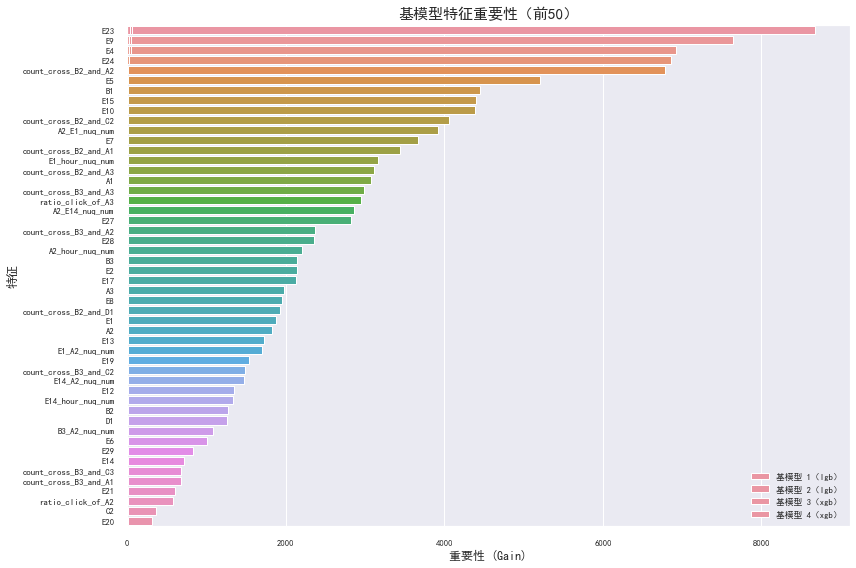

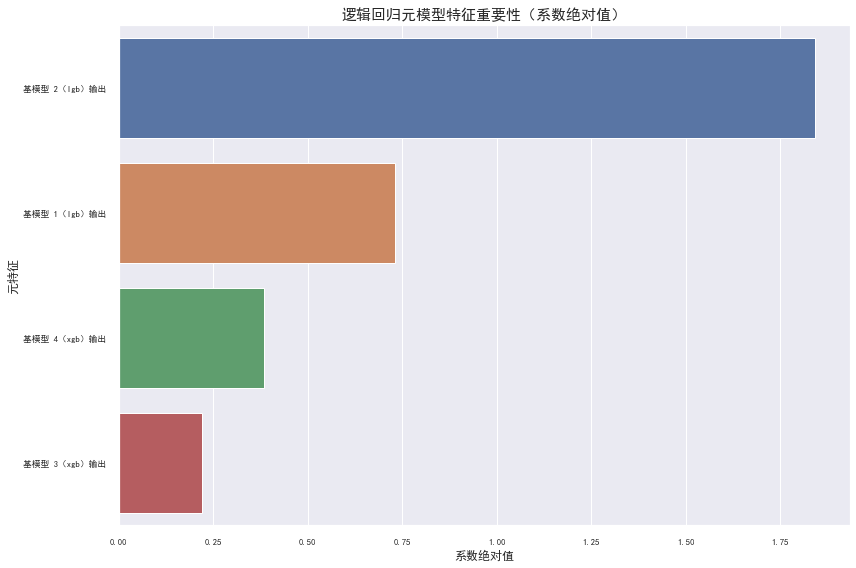

In [6]:
# 特征重要性可视化（适配逻辑回归元模型）
def plot_feature_importance(models, meta_model, feature_names, top_n=50, figsize=(12, 8)):
    # 基模型特征重要性
    plt.figure(figsize=figsize)
    for i, model_info in enumerate(models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            importance = model.feature_importance(importance_type='gain')
        elif model_type == 'xgb':
            importance_dict = model.get_score(importance_type='gain')
            importance = [importance_dict.get(f, 0) for f in feature_names]
        
        feat_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importance,
            'model': f'基模型 {i+1}（{model_type}）'
        })
        top_feat = feat_imp.sort_values('importance', ascending=False).head(top_n)
        sns.barplot(x='importance', y='feature', data=top_feat, label=f'基模型 {i+1}（{model_type}）')
    
    plt.title(f'基模型特征重要性（前{top_n}）', fontsize=15)
    plt.xlabel('重要性 (Gain)', fontsize=12)
    plt.ylabel('特征', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 逻辑回归元模型特征重要性（系数）
    plt.figure(figsize=figsize)
    meta_coef = meta_model.coef_[0]  # 逻辑回归系数
    meta_feat_imp = pd.DataFrame({
        'feature': [f'基模型 {i+1}（{models[i]["type"]}）输出' for i in range(len(models))],
        'importance': np.abs(meta_coef)  # 用系数绝对值表示重要性
    })
    meta_feat_imp = meta_feat_imp.sort_values('importance', ascending=False)
    
    sns.barplot(x='importance', y='feature', data=meta_feat_imp)
    plt.title('逻辑回归元模型特征重要性（系数绝对值）', fontsize=15)
    plt.xlabel('系数绝对值', fontsize=12)
    plt.ylabel('元特征', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_feature_importance(models, meta_model, features)

In [7]:
# 多指标评估函数
def calculate_metrics(y_true, y_pred_proba):
    auc = roc_auc_score(y_true, y_pred_proba)
    
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ks = max(tpr - fpr)
    
    thresholds = np.arange(0.1, 1.0, 0.1)
    f1_scores = []
    precision_scores = []
    recall_scores = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1_scores.append(f1_score(y_true, y_pred))
        precision_scores.append(precision_score(y_true, y_pred))
        recall_scores.append(recall_score(y_true, y_pred))
    
    best_f1_idx = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_idx]
    best_threshold = thresholds[best_f1_idx]
    
    return {
        'auc': auc,
        'ks': ks,
        'best_f1': best_f1,
        'best_threshold': best_threshold,
        'thresholds': thresholds,
        'f1_scores': f1_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores
    }

# 评估指标可视化
def plot_metrics(metrics, figsize=(15, 10)):
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('模型评估指标', fontsize=16)
    
    # 关键指标
    ax1 = axes[0, 0]
    metrics_text = f"AUC: {metrics['auc']:.4f}\nKS: {metrics['ks']:.4f}\n最佳F1: {metrics['best_f1']:.4f}\n最佳阈值: {metrics['best_threshold']:.2f}"
    ax1.text(0.5, 0.5, metrics_text, fontsize=14, ha='center', va='center')
    ax1.set_title('关键指标值')
    ax1.axis('off')
    
    # ROC曲线
    ax2 = axes[0, 1]
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    ax2.plot(fpr, tpr, label=f'ROC曲线 (AUC = {metrics["auc"]:.4f})')
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('假正例率 (FPR)')
    ax2.set_ylabel('真正例率 (TPR)')
    ax2.set_title('ROC曲线')
    ax2.legend()
    
    # KS曲线
    ax3 = axes[1, 0]
    ax3.plot(fpr, label='FPR')
    ax3.plot(tpr, label='TPR')
    ax3.plot(tpr - fpr, label=f'KS ({metrics["ks"]:.4f})')
    ax3.set_xlabel('阈值')
    ax3.set_ylabel('比例')
    ax3.set_title('KS曲线')
    ax3.legend()
    
    # 阈值相关指标
    ax4 = axes[1, 1]
    ax4.plot(metrics['thresholds'], metrics['f1_scores'], label='F1分数')
    ax4.plot(metrics['thresholds'], metrics['precision_scores'], label='精确率')
    ax4.plot(metrics['thresholds'], metrics['recall_scores'], label='召回率')
    ax4.axvline(x=metrics['best_threshold'], color='r', linestyle='--', label=f'最佳阈值: {metrics["best_threshold"]:.2f}')
    ax4.set_xlabel('阈值')
    ax4.set_ylabel('分数')
    ax4.set_title('不同阈值下的分类指标')
    ax4.legend()
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# 模型评估与可视化
print("\n交叉验证评估结果与可视化...")
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
final_auc_scores = []
final_ks_scores = []
final_f1_scores = []

y_val = None
y_pred_proba = None

for fold, (train_idx, val_idx) in enumerate(kf.split(train_x, train_y)):
    val_meta_features = np.zeros((len(val_idx), len(models)))
    
    if isinstance(train_x, pd.DataFrame):
        X_val = train_x.iloc[val_idx]
    else:
        X_val = train_x[val_idx]
    
    for i, model_info in enumerate(models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            val_meta_features[:, i] = model.predict(X_val, num_iteration=model.best_iteration)
        elif model_type == 'xgb':
            xgb_val = xgb.DMatrix(X_val)
            val_meta_features[:, i] = model.predict(xgb_val, ntree_limit=model.best_iteration)
    
    # 逻辑回归预测（需要标准化）
    val_meta_scaled = scaler.transform(val_meta_features)
    y_pred = meta_model.predict_proba(val_meta_scaled)[:, 1]  # 取正例概率
    auc = roc_auc_score(train_y[val_idx], y_pred)
    
    metrics = calculate_metrics(train_y[val_idx], y_pred)
    
    final_auc_scores.append(auc)
    final_ks_scores.append(metrics['ks'])
    final_f1_scores.append(metrics['best_f1'])
    
    if fold == kf.n_splits - 1:
        y_val = train_y[val_idx]
        y_pred_proba = y_pred
        fold_metrics = metrics

print(f"最终Stacking模型的平均AUC: {np.mean(final_auc_scores):.4f} ± {np.std(final_auc_scores):.4f}")
print(f"最终Stacking模型的平均KS: {np.mean(final_ks_scores):.4f} ± {np.std(final_ks_scores):.4f}")
print(f"最终Stacking模型的平均最佳F1: {np.mean(final_f1_scores):.4f} ± {np.std(final_f1_scores):.4f}")


交叉验证评估结果与可视化...
最终Stacking模型的平均AUC: 0.8149 ± 0.0447
最终Stacking模型的平均KS: 0.4821 ± 0.0686
最终Stacking模型的平均最佳F1: 0.5032 ± 0.0479


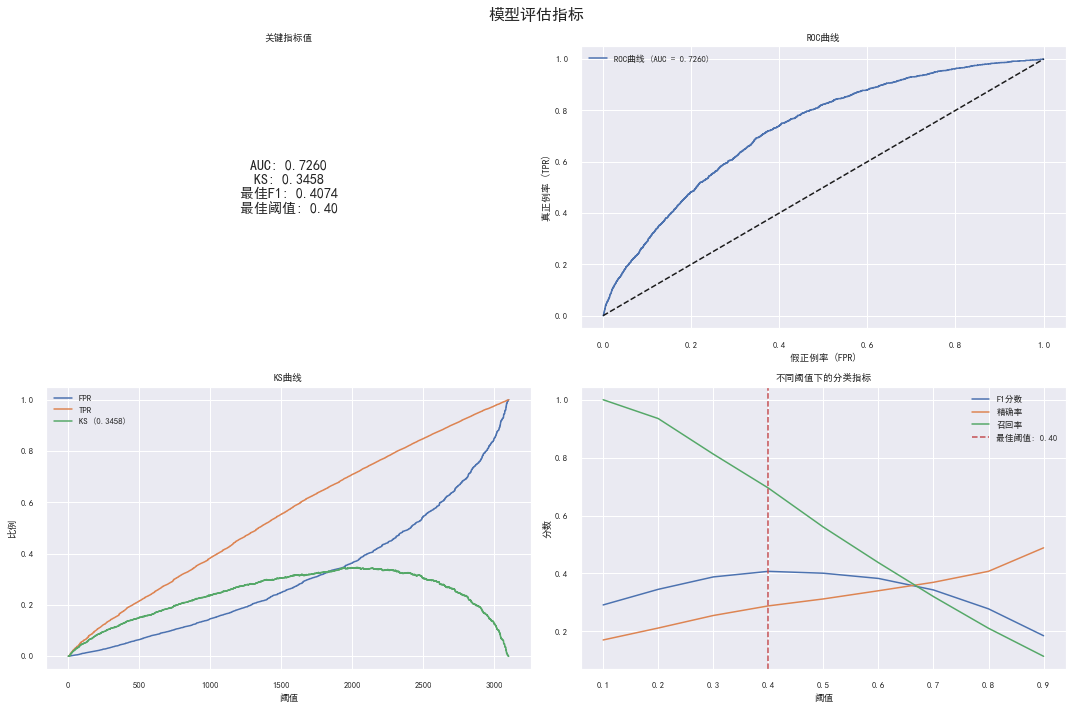

In [8]:
plot_metrics(fold_metrics)

In [9]:
# 保存模型
print("\n保存模型...")
stacking_model = {
    'base_models': models,
    'meta_model': meta_model,
    'scaler': scaler,  # 保存标准化器
    'model_params': model_params
}

with open('./models/stacking_model_logistic.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

print("模型已保存为 stacking_model_logistic.pkl")




保存模型...
模型已保存为 stacking_model_logistic.pkl


In [10]:
# 预测函数
def predict_with_model(model_path, X):
    with open(model_path, 'rb') as f:
        stacking_model = pickle.load(f)
    
    base_models = stacking_model['base_models']
    meta_model = stacking_model['meta_model']
    scaler = stacking_model['scaler']  # 加载标准化器
    
    meta_features = np.zeros((X.shape[0], len(base_models)))
    for i, model_info in enumerate(base_models):
        model = model_info['model']
        model_type = model_info['type']
        
        if model_type == 'lgb':
            meta_features[:, i] = model.predict(X, num_iteration=model.best_iteration)
        elif model_type == 'xgb':
            dmatrix = xgb.DMatrix(X)
            meta_features[:, i] = model.predict(dmatrix, ntree_limit=model.best_iteration)
    
    # 逻辑回归预测（标准化元特征）
    meta_features_scaled = scaler.transform(meta_features)
    predictions = meta_model.predict_proba(meta_features_scaled)[:, 1]  # 取正例概率
    
    return predictions

# 执行预测
predictions = predict_with_model('./models/stacking_model_logistic.pkl', test_x)

sub['label'] = predictions
sub.to_csv('./sub/stacking_model_logistic.csv',index = False)

print("预测结果:", predictions)

预测结果: [0.14025979 0.31467204 0.56408674 ... 0.60245127 0.19003548 0.4095843 ]
